# Volume 3: Metropolis Algorithm
    Benj McMullin
    Math 405
    1/23/2024

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from math import sqrt, exp, log
import seaborn as sbn

## Problem 1

Write a function that uses the Metropolis Hastings algorithm to draw from the posterior distribution over the mean $\mu$ and variance $\sigma^2$. Use the given functions and Algorithm 1 to complete the problem.

Your function should return an array of draws, an array of the log probabilities, and an acceptance rate. 
Create plots resembling Figures 1 and 2:
 - Plot the log probabilities of the first 500 samples.
 - Plot the samples for $\mu$ in the order they were drawn, and likewise for $\sigma^2$.
 - Using `seaborn.kdeplot` plot the distribution of all samples for $\mu$, and likewise for $\sigma^2$.

Use $u=20$ for the parameter of the proposal function.
Use the initial state $\mathbf{y}_0=(\mu_0,\sigma^2_0)=(40,10)$.
Take 10,000 samples for both $\mu$ and $\sigma^2$. 

Compare your results with Figures 1 and 2.

In [7]:
def proposal(x,s):
    """The proposal function Q(x,y) = N(x|y,sI)."""
    return stats.multivariate_normal.rvs(mean=x, cov=s*np.eye(len(x)))

In [8]:
def propLogDensity(x):
    """Calculate the log of the proportional density."""
    logprob = muprior.logpdf(x[0]) + sig2prior.logpdf(x[1])
    logprob += stats.norm.logpdf(scores, loc=x[0], scale=np.sqrt(x[1])).sum()
    return logprob    # ^this is where the scores are used.

In [9]:
def acceptance(x, y):
    return min(0, propLogDensity(x) - propLogDensity(y))

In [10]:
def metropolis(y0, s, n_samples):
    """
    Use the Metropolis algorithm to sample from posterior.
    Parameters:
        x0 ((2,) ndarray): The first entry is mu, the second entry is sigma^2.
        u (float): The standard deviation parameter for the proposal function.
        n_samples (int): The number of samples to generate.
        muprior, sig2prior (scipy.stats distributions): The prior distributions for mu and sigma^2.
        scores ((N,) ndarray): The array of exam scores
    
    Returns:
        draws ((n_samples, 2) ndarray): The MCMC samples.
        logprobs ((n_samples,) ndarray): The values of log f(y) of the samples.
        accept_rate (float): The proportion of accepted proposed samples.
    """
    # Initialize arrays to store samples and logprobs
    y = [y0]
    log_probs = [propLogDensity(y[0])]
    count = 0
    
    # Generate samples and logprobs using Metropolis algorithm
    for t in range(1, n_samples):
        # Propose new sample
        x = proposal(y[t-1], s)
        a = np.random.uniform(0,1)
        
        # Accept or reject sample
        if log(a) <= acceptance(x, y[t-1]):
            y.append(x)
            count += 1
        else:
            y.append(y[t-1])
        log_probs.append(propLogDensity(y[t]))
        
    # Calculate acceptance rate
    acceptance_rate = n_samples / count
    
    return y, log_probs, acceptance_rate

In [14]:
# Set random seed for reproducibility of results
np.random.seed(7)
# Load in the data and initialize priors
scores = np.load("examscores.npy")
# Prior sigma^2 ~ IG(alpha, beta)
alpha = 3
beta = 50
# Prior mu ~ N(m, s)
m = 80
s = 4

muprior = stats.norm(loc=m, scale=sqrt(s**2))
sig2prior = stats.invgamma(alpha, scale = beta)

n_samples = 10000

# Run Metropolis algorithm
y, logprobs, accept_rate = metropolis((40, 20), s, n_samples)

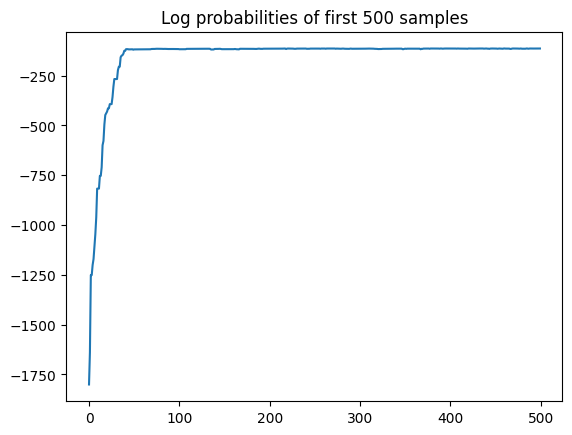

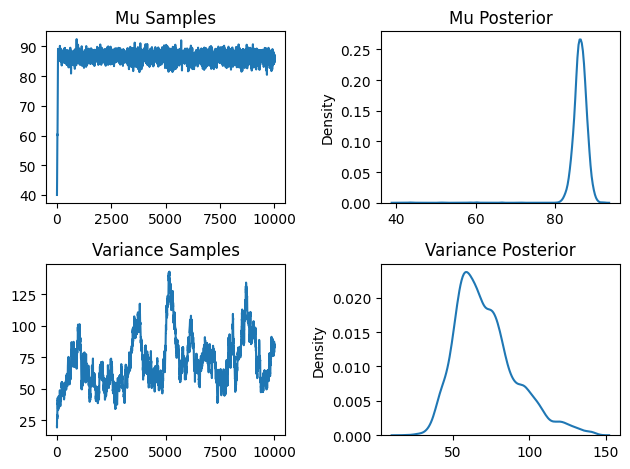

In [16]:
# Print acceptance rate
y = np.array(y)

# Plot results of Metropolis algorithm for Log probabilities of first 500 samples
plt.plot(logprobs[:500])
plt.title("Log probabilities of first 500 samples")
plt.show()

# Plot Mu samples
plt.subplot(221)
plt.plot(y[:,0])
plt.title("Mu Samples")

# Plot Mu posterior
plt.subplot(222)
sbn.kdeplot(y[:,0])
plt.title("Mu Posterior")

# Plot Variance samples
plt.subplot(223)
plt.plot(y[:,1])
plt.title("Variance Samples")

# Plot Variance posterior
plt.subplot(224)
sbn.kdeplot(y[:,1])
plt.title("Variance Posterior")

plt.tight_layout()
plt.show()

## Problem 2

Write a function that accepts a spin configuration $\sigma$ for a lattice as a NumPy array.
Compute the energy $H(\sigma)$ of the spin configuration.
Be careful to not double count site pair interactions!

In [17]:
def random_lattice(n):
    """Construct a random spin configuration for an nxn lattice."""
    random_spin = np.zeros((n,n))
    for k in range(n):
        random_spin[k,:] = 2*np.random.binomial(1,.5, n) -1
    return random_spin

In [18]:
def lattice_energy(L):
    """Computer the energy of the spin configuration corresponding to the
    lattice L.
    Parameter:
     L (ndarray): A lattice that we want the spin configuration for.
    
    Returns:
     (float): The spinfiguration of the lattice.
    """
    # Compute the horizontal and vertical energy
    horiz = -1 * np.multiply(L, np.roll(L, 1, axis = 0))
    vert = -1 * np.multiply(L, np.roll(L, 1, axis = 1))
    
    return horiz.sum() + vert.sum()

## Problem 3

Write a function that accepts an integer $n$ and chooses a pair of indices $(i,j)$ where $0 \le i,j \le n-1$.
Each possible pair should have an equal probability $\frac{1}{n^2}$ of being chosen.

In [19]:
def flip_location(n):
    """Choose a random pair of indices 0 <= i,j <= n-1.
    Parameter:
     n (int): 1/(n^2) probability for each location
     
    Returns:
     (index1, index2) (tuple): the tuple pair of the chosen indices. 
    """
    # Choose a random pair of indices 0 <= i,j <= n-1
    i = int(np.random.uniform(0, n - 1))
    j = int(np.random.uniform(0, n - 1))
    
    # Return the pair of indices
    return (i, j)  

## Problem 4

Write a function that accepts a spin configuration $\sigma$, its energy $H(\sigma)$, and integer indices $i$ and $j$.
Compute the energy of the new spin configuration $\sigma^*$, which is $\sigma$ but with the spin flipped at the $(i,j)$ th entry of the corresponding lattice.
Do not explicitly construct the new lattice for $\sigma^*$.

In [20]:
def updated_energy(L, L_energy, i, j):
    """Compute the energy of the spin configuration that results
    when the (i,j)th spin of L is flipped.
    
    Parameters:
     L (ndarray): the spin configuration 
     L_energy (float): the energy of the spin configuration.
     i (int): the first index.
     j (int): the second index.
    Returns:
     (float): the energy of the new updated lattice
    """
    # Compute the energy of the spin configuration that results
    r = L[i, j] * L[i, j + 1]
    l = L[i, j] * L[i, j - 1]
    u = L[i, j] * L[i + 1, j]
    d = L[i, j] * L[i - 1, j]
    
    # Compute the energy of the new updated lattice
    newH = L_energy + 2 * (r + l + u + d)
    
    return newH

## Problem 5

Write a function that accepts a float $\beta$ and spin configuration energies $H(\sigma)$ and $H(\sigma^*)$.
Calculate whether or not the new spin configuration $\sigma^*$ should be accepted (return `True` or `False`).

(Hint: np.random.binomial() might be useful function)

In [21]:
def accept(beta, energy_old, energy_new):
    """Accept or reject the new spin configuration.
    
    Parameters:
     beta (float): a quantity inversly proportional to the temperature.
     energy_old (float): the energy of the old lattice.
     energy_new (float): the energy of the updated lattice.
     
    Returns:
     (boolean): whether the new energy should be accepted or not
    """
    # Define the accept function
    def A(H_old, H_new):
        """Accept function"""
        # If the new energy is less than the old energy, accept
        if H_old > H_new:

            return 1
        
        # Else, accept with probability exp(beta * (H_old - H_new))
        else:
            return np.exp(beta * (H_old - H_new))
    
    # Draw from this bernouli
    good = np.random.binomial(1, A(energy_old, energy_new))
    
    return bool(good)

## Problem 6

Write a function that accepts a float $\beta>0$ and integers $n$, `n_samples`, and `burn_in`.
Initialize an $n\times n$ lattice for a spin configuration $\sigma$ using `random_lattice()`.
Use the Metropolis algorithm to (potentially) update the lattice `burn_in` times.
1. Use `flip_location()` to choose a site for possibly flipping the spin, thus defining a potential new configuration $\sigma^*$.
2. Use `updated_energy()` to calculate the energy $H(\sigma^*)$ of the proposed configuration.
3. Use `accept()` to accept or reject the proposed configuration. If it is accepted, set $\sigma = \sigma^*$ by flipping the spin at the indicated site.
4. Track $-\beta H(\sigma)$ at each iteration (independent of acceptance).

After the burn-in period, continue the iteration `n_samples` times, also recording every $100$th sample (to prevent memory failure).
Return the samples, the sequence of weighted energies $-\beta H(\sigma)$, and the acceptance rate.

Test your sampler on a $100 \times 100$ grid with $200000$ total iterations, with `n_samples` large enough so that you will keep $50$ samples, for $\beta = 0.2, 0.4, 1$.
Plot the proportional log probabilities, as well as a late sample from each test.


In [24]:
def using_metropolis(beta, n=100, n_samples=5000, burn_in=195000):
    """Use the Metropolis algorithm to choose new spin configurations.

    Parameters:
        beta (float > 0): Constant inversely proportional to the temperature.
        N (int > 0): The size of the lattice.
        n_samples (int): The number of samples to generate.
        burnin (int): The number of iterations to burn before sampling.

    Returns:
        ((n_samples//100, n,n) ndarray): The sampled spin configurations.
        (n_samples) ndarray: The weighted energies of each configuration.
        (float): The proportion of proposed samples that were accepted.
    """
    # Initialize arrays to store samples and logprobs
    Ls = []
    weighted_energies = []
    count = 0
    L = random_lattice(n)
    energy = lattice_energy(L)
    
    # Generate samples and logprobs using Metropolis algorithm
    for k in range(200000):

        # Use the flip_location function to choose a random pair of indices
        (i, j) = flip_location(n)

        # Compute the energy of the spin configuration that results
        new_energy = updated_energy(L, energy, i, j)

        # Accept or reject sample
        accepted = accept(beta, energy, new_energy)
        if accepted:
            energy = new_energy
            L[i, j] = -L[i, j]
            if k > burn_in:
                count += 1

        # Append the energy
        weighted_energies.append(-beta * energy)
            
       # Save L every 100 steps after burn in
        if k > burn_in and k % 100 == 0:
            Ls.append(L)
            
    return Ls, weighted_energies, n_samples / count

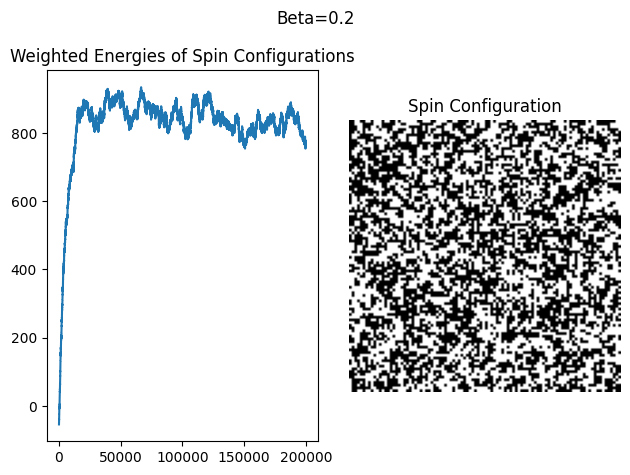

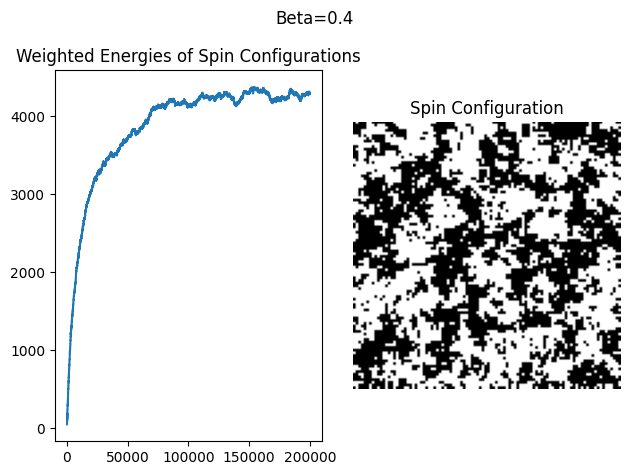

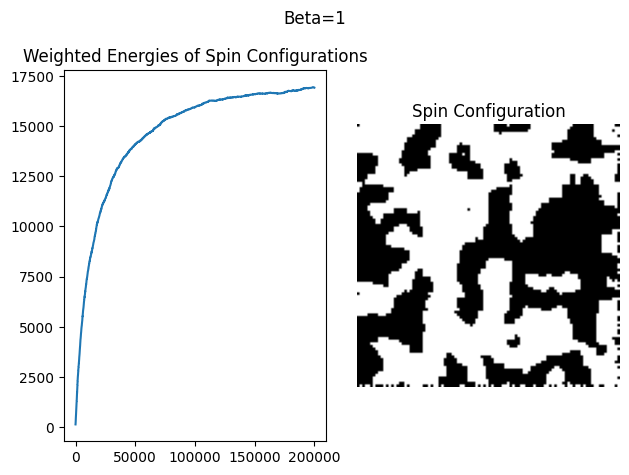

In [26]:
# Run Metropolis algorithm for different values of beta and plot results
for beta in [.2, .4, 1]:
    Ls, energies, rate = using_metropolis(beta)
    
    # Plot results
    plt.subplot(121)
    plt.plot([i for i in range(1,len(energies)+1)], energies)
    plt.title("Weighted Energies of Spin Configurations")
    plt.suptitle(f"Beta={beta}")
    plt.subplot(122)
    plt.imshow(Ls[-1], cmap='gray')
    plt.title("Spin Configuration")
    plt.axis("off")
    plt.tight_layout()
    plt.show()